In [1]:
from pathlib import Path
from tqdm import tqdm_notebook

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import torch

import fastai
from fastai.text import *

In [2]:
DATA_PATH = Path('../data')
tqdm_notebook().pandas()

In [3]:
text_cols = ['title', 'text']

In [4]:
train_df = pd.read_csv(DATA_PATH/'train.csv').fillna('<EMPTY>')
valid_df = pd.read_csv(DATA_PATH/'valid.csv').fillna('<EMPTY>')
test_df = pd.read_csv(DATA_PATH/'test.csv', index_col=0).fillna('<EMPTY>')
# unlabeled_df = pd.read_csv(DATA_PATH/'unlabeled.csv', index_col=0).fillna('<EMPTY>')

full_unlabeled_df = pd.concat([train_df[text_cols], valid_df[text_cols], test_df[text_cols]], 
                              axis=0, ignore_index=True)
full_unlabeled_df.to_csv(DATA_PATH/'full_unlabeled.csv', index=False, header=True)

full_train_df = pd.concat([train_df, valid_df], axis=0, ignore_index=True)
full_train_df.to_csv(DATA_PATH/'full_train.csv', index=False, header=True)

test_df.to_csv(DATA_PATH/'full_test.csv', index=False, header=True)

In [5]:
# data_lm.save(DATA_PATH/'data_lm_export.pkl')
data_lm = load_data(DATA_PATH, 'data_lm_export.pkl')

In [6]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3).clip_grad(0.1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.74E-02


0.017378008287493762

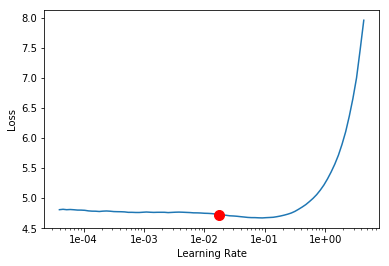

In [12]:
learn.lr_find(start_lr = slice(10e-8, 10e-6), end_lr=slice(0.1, 10))
learn.recorder.plot(suggestion=True)

best_lm_lr = learn.recorder.min_grad_lr
best_lm_lr

In [13]:
learn.fit_one_cycle(1, best_lm_lr)

epoch,train_loss,valid_loss,accuracy,time
0,4.146567,3.957749,0.319999,36:06


In [14]:
learn.save('lm_freezed_3')
learn.save_encoder('lm_enc_freezed_3')

In [7]:
learn = learn.load('lm_freezed_3')

In [15]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.94E-04


0.0007943282347242812

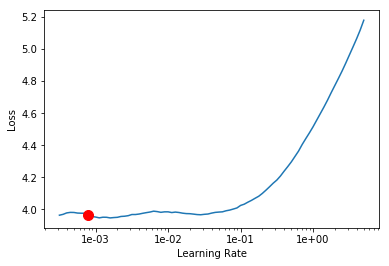

In [16]:
learn.lr_find(start_lr = slice(10e-7, 10e-5), end_lr=slice(0.1, 10))
learn.recorder.plot(suggestion=True)

best_lm_lr = learn.recorder.min_grad_lr
best_lm_lr

In [17]:
learn.fit_one_cycle(1, best_lm_lr)

epoch,train_loss,valid_loss,accuracy,time
0,3.747036,3.722839,0.345868,40:23


In [19]:
learn.save('lm_unfreezed_3')
learn.save_encoder('lm_enc_unfreezed_3')

In [7]:
learn = learn.load('lm_unfreezed_3')

In [8]:
data_clas = TextClasDataBunch.from_csv(path=DATA_PATH, 
                                       csv_name='full_train.csv',
                                       test='full_test.csv',
                                       vocab=data_lm.train_ds.vocab, 
                                       bs=16,
                                       text_cols=text_cols, 
                                       label_cols='label')

In [8]:
#data_clas.save(DATA_PATH/'data_clas_export.pkl')
data_clas = load_data(DATA_PATH, 'data_clas_export.pkl', bs=16)

In [9]:
learn_clas = text_classifier_learner(data_clas, drop_mult=0.5, arch=AWD_LSTM).clip_grad(10)

In [10]:
learn_clas.load_encoder('lm_enc_unfreezed_3')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.16E-04


0.000316227766016838

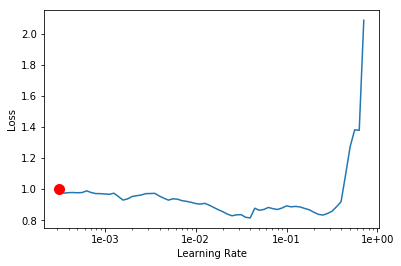

In [11]:
learn_clas.lr_find(start_lr = slice(10e-7, 10e-5), end_lr=slice(0.1, 10))
learn_clas.recorder.plot(suggestion=True)

best_clf_lr = learn_clas.recorder.min_grad_lr
best_clf_lr

In [12]:
learn_clas.fit_one_cycle(1, 1e-02)

epoch,train_loss,valid_loss,accuracy,time
0,0.426264,0.318651,0.874055,57:55


In [14]:
learn_clas.save('clf_freezed_3')

In [11]:
learn_clas = learn_clas.load('clf_freezed_3')

In [12]:
learn_clas.freeze_to(-2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.55E-06


9.549925860214365e-06

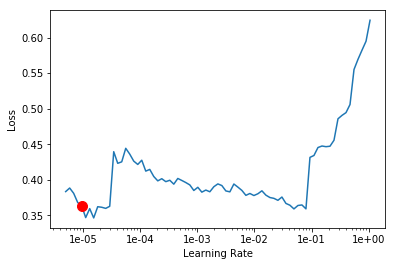

In [16]:
learn_clas.lr_find(start_lr = slice(10e-9, 10e-7), end_lr=slice(0.1, 10))
learn_clas.recorder.plot(suggestion=True)

best_clf_lr = learn_clas.recorder.min_grad_lr
best_clf_lr

In [17]:
learn_clas.fit_one_cycle(1, slice(5e-3/100, 5e-3))

epoch,train_loss,valid_loss,accuracy,time


KeyboardInterrupt: 

In [15]:
learn_clas.save('clf_unfreezed_2_3')

In [18]:
learn_clas = learn_clas.load('clf_unfreezed_2_3')

In [19]:
learn_clas.unfreeze()

In [20]:
learn_clas.lr_find(start_lr = slice(10e-7, 10e-5), end_lr=slice(0.1, 10))
learn_clas.recorder.plot(suggestion=True)

best_clf_lr = learn_clas.recorder.min_grad_lr
best_clf_lr

Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/opt/anaconda3/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/anaconda3/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/opt/anaconda3/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
  File "/opt/anaconda3/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/opt/anaconda3/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/anaconda3/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
Traceback (most recent call last):
  

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


KeyboardInterrupt: 

In [29]:
learn_clas.fit_one_cycle(1, best_clf_lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.377687,0.292185,0.884257,1:14:22


In [30]:
learn_clas.save('clf_unfreezed_all_3')

In [31]:
learn_clas.show_results()

text,target,prediction
"xxbos 2017 xxmaj power xxmaj rankings : xxmaj best and worst case for every team xxmaj when 2016 ended , the xxmaj chicago xxmaj cubs were on top of the baseball world as xxmaj world xxmaj series champions for the first time since 1908 . xxmaj with the bulk of their team returning , the xxmaj cubs unsurprisingly open 2017 in the same place in our rankings . xxmaj who",news,news
"xxbos xxmaj america ’s xxmaj best xxmaj states to xxmaj live xxmaj in xxmaj more xxmaj try xxmaj yahoo xxmaj finance on xxmaj firefox » xxmaj americans often evaluate their home states according to such subjective conditions as climate preference , the presence of friends and family , and personal history . xxmaj in addition to these subjective measures , more objective socioeconomic factors also contribute to life satisfaction",clickbait,news
"xxbos xxmaj the 50 xxmaj best xxmaj podcasts of 2016 xxmaj gone are the days of explaining what a podcast is : xxmaj the arrival of money to the form and a continued increase in listeners has led to another banner year and the premiere of hundreds of shows to suit any listener ’s audio preferences . xxmaj whether it ’s entrepreneurial advice , video game breakdowns , or candid",news,news
"xxbos xxmaj trump ’s xxmaj interests vs. xxmaj america ’s , xxmaj las xxmaj vegas xxmaj edition xxmaj on top of owning various properties and enterprises , xxmaj trump and his company employ roughly 34 , 000 people , according to an analysis by xxup cnn . xxmaj on xxmaj december 21 , several hundred of those workers resolved a labor dispute against the — one in which , had",news,news
"xxbos xxmaj thursday xxup nba xxmaj roundup : xxmaj westbrook 's xxup mvp xxmaj chances xxmaj remain xxmaj strong , but xxmaj winning xxmaj matters xxmaj when the xxup nba names the 2016 - 17 xxup mvp , a game from early xxmaj january could loom large for xxmaj james xxmaj harden and xxmaj russell xxmaj westbrook . xxmaj after all , the xxmaj houston xxmaj rockets ' 118 -",news,news


In [33]:
test_preds = np.concatenate([learn_clas.predict(item=test_df.iloc[i])[2].cpu().numpy().reshape(1, -1)
                            for i in tqdm_notebook(range(len(test_df)))], axis=0)

In [ ]:
test_preds.to_csv(DATA_PATH/'test_preds', index=False)

In [34]:
test_pred_df = pd.DataFrame(test_preds, columns=['clickbait', 'news', 'other'])
ulmfit_preds = pd.Series(np.argmax(test_pred_df.values, axis=1),
                        name='label').map({0: 'clickbait', 1: 'news', 2: 'other'})

In [36]:
ulmfit_preds.head()

0    news
1    news
2    news
3    news
4    news
Name: label, dtype: object

In [37]:
ulmfit_preds.to_csv('ulmfit_predictions.csv', index_label='id', header=True)

In [40]:
!head 'ulmfit_predictions.csv'

id,label
0,news
1,news
2,news
3,news
4,news
5,news
6,news
7,news
8,news


In [41]:
!wc -l ulmfit_predictions.csv

5648 ulmfit_predictions.csv


In [42]:
!kaggle competitions submit -c dlinnlp-spring-2019-clf -f ulmfit_predictions.csv -m "ULMFiT Baseline"

100%|██████████████████████████████████████| 56.9k/56.9k [00:05<00:00, 11.3kB/s]
Successfully submitted to DL in NLP Spring 2019. Classification